# Assignment 3 by: YourFullName (YourStudentID)


## EDA

In [148]:
ls

catboost_info/    README.txt
cleaned_data.csv  saved_test_predictions_with_titles.csv
filled_data.csv   top_20_recommendations_svd_catboost.csv
movies.dat        user_movie_ratings_filled.csv
ratings.dat       users.dat


In [149]:
cd ./ml-1m

[Errno 2] No such file or directory: './ml-1m'
/home/rick/Desktop/Nhat/ml-1m


In [150]:
# pip install modin[dask] dask

In [151]:
# !pip install modin==0.12.1 pandas==1.3.3

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [152]:
# !pip install bottleneck==1.3.6

In [153]:
# !pip install pandas numpy scikit-learn matplotlib scipy seaborn lightfm

In [154]:
# !pip install lightfm

## Data Loading

In [155]:
df_user = pd.read_csv('users.dat', sep='::', engine='python', names=['UserID','Gender','Age','Occupation',"Zip-code"])
df_movies = pd.read_csv('movies.dat', sep='::', engine='python', names=["MovieID","Title","Genres"], encoding='latin-1')
df_ratings = pd.read_csv('ratings.dat', sep='::', engine='python', names=["UserID","MovieID","Rating","Timestamp"])


In [156]:
df_user.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [157]:
df_movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [158]:
df_ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [159]:
from sklearn.preprocessing import MultiLabelBinarizer

def clean_recommender_data(df_user, df_ratings, df_movies):
    # Merge dataframes based on 'UserID' and 'MovieID'
    df_merged = pd.merge(df_user, df_ratings, on='UserID')
    df_merged = pd.merge(df_merged, df_movies, on='MovieID')
    
    # Drop rows with missing values
    df_clean = df_merged.dropna()
    
    # Remove duplicate rows
    df_clean = df_clean.drop_duplicates()
    
    # Ensure the correct data types
    df_clean['UserID'] = df_clean['UserID'].astype(int)
    df_clean['MovieID'] = df_clean['MovieID'].astype(int)
    df_clean['Rating'] = df_clean['Rating'].astype(float)
    
    # Strip trailing/leading whitespace from 'Gender' and 'Title' columns
    if 'Gender' in df_clean.columns:
        df_clean['Gender'] = df_clean['Gender'].str.strip()

    if 'Title' in df_clean.columns:
        df_clean['Title'] = df_clean['Title'].str.strip()
    
    # Check for ratings out of range and remove invalid ones
    df_clean = df_clean[(df_clean['Rating'] >= 1) & (df_clean['Rating'] <= 5)]
    
    # Split the Genres column into multiple genres
    df_clean['Genres'] = df_clean['Genres'].str.split('|')

    # Apply Multi-Hot Encoding (One-Hot Encoding) to the Genres column
    mlb = MultiLabelBinarizer()
    genre_encoded = mlb.fit_transform(df_clean['Genres'])

    # Create a DataFrame with the one-hot encoded genres and join with the original DataFrame
    df_genre_encoded = pd.DataFrame(genre_encoded, columns=mlb.classes_, index=df_clean.index)
    
    # Concatenate the encoded genres back to the original DataFrame
    df_clean = pd.concat([df_clean, df_genre_encoded], axis=1)
    
    # # Drop the original Genres column
    # df_clean.drop('Genres', axis=1, inplace=True)
    
    # Optional: Filter out users and movies with few interactions (for sparse data)
    user_counts = df_clean['UserID'].value_counts()
    movie_counts = df_clean['MovieID'].value_counts()

    # Keep users with at least 5 ratings and movies with at least 10 ratings
    df_clean = df_clean[df_clean['UserID'].isin(user_counts[user_counts >= 5].index)]
    df_clean = df_clean[df_clean['MovieID'].isin(movie_counts[movie_counts >= 10].index)]
    
    return df_clean

# Usage example:
# Assuming df_user, df_ratings, and df_movies are your input DataFrames
df_cleaned = clean_recommender_data(df_user, df_ratings, df_movies)

In [160]:
df_cleaned.head()

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Rating,Timestamp,Title,Genres,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,F,1,10,48067,1193,5.0,978300760,One Flew Over the Cuckoo's Nest (1975),[Drama],...,0,0,0,0,0,0,0,0,0,0
1,1,F,1,10,48067,661,3.0,978302109,James and the Giant Peach (1996),"[Animation, Children's, Musical]",...,0,0,0,1,0,0,0,0,0,0
2,1,F,1,10,48067,914,3.0,978301968,My Fair Lady (1964),"[Musical, Romance]",...,0,0,0,1,0,1,0,0,0,0
3,1,F,1,10,48067,3408,4.0,978300275,Erin Brockovich (2000),[Drama],...,0,0,0,0,0,0,0,0,0,0
4,1,F,1,10,48067,2355,5.0,978824291,"Bug's Life, A (1998)","[Animation, Children's, Comedy]",...,0,0,0,0,0,0,0,0,0,0


In [161]:
df_cleaned['Title'].nunique()

3260

In [162]:
df_cleaned.to_csv('cleaned_data.csv', index=False)

In [163]:
# !pip install fuzzywuzzy python-Levenshtein

# EDA



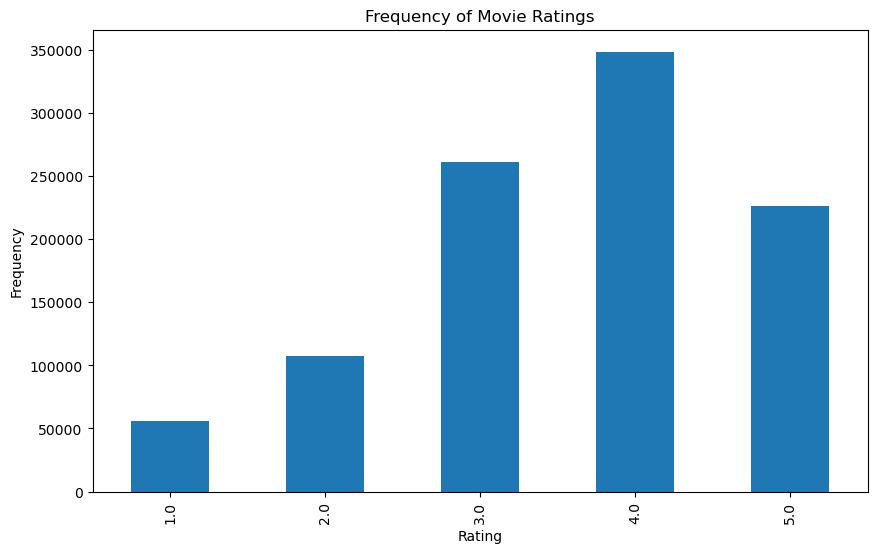

In [164]:
# Plot the frequency of movie ratings
plt.figure(figsize=(10, 6))
df_cleaned['Rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Frequency of Movie Ratings')
plt.show()

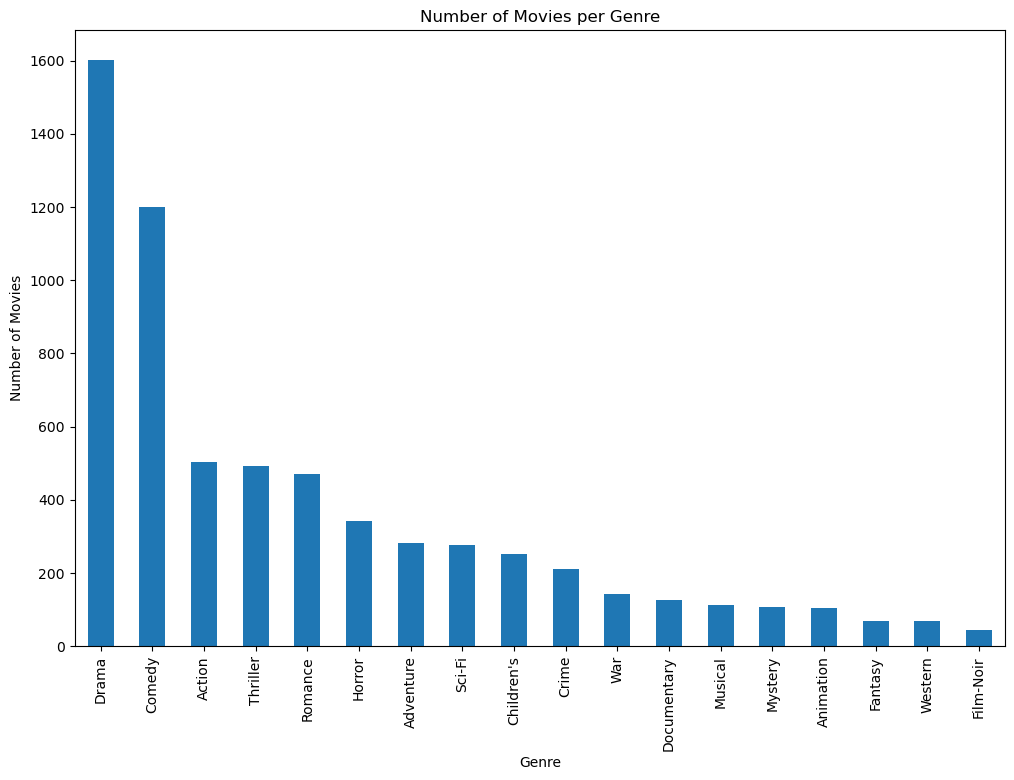

In [165]:
# Extract genres and count the occurrences
genre_counts = df_movies['Genres'].str.split('|').explode().value_counts()

# Plot the genre counts
plt.figure(figsize=(12, 8))
genre_counts.plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Number of Movies per Genre')
plt.show()

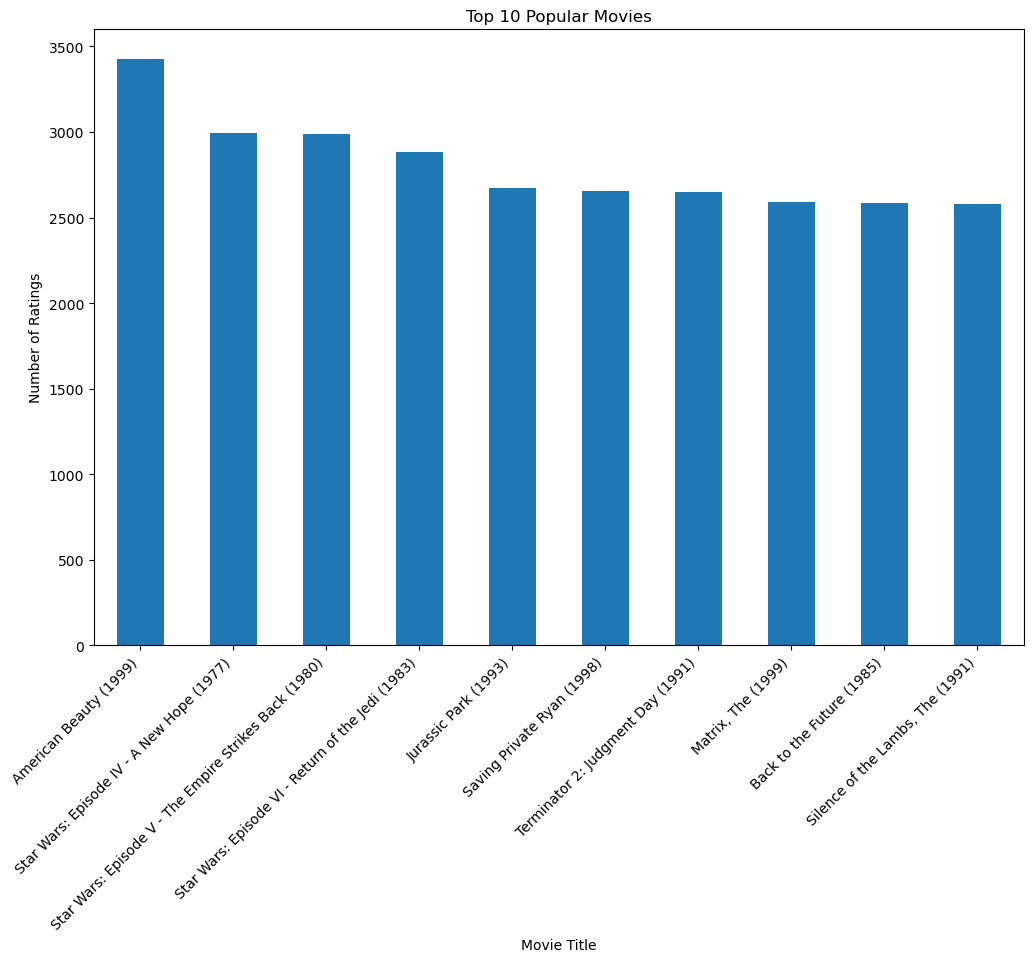

In [166]:
# Calculate the number of ratings for each movie
movie_ratings_count = df_cleaned['Title'].value_counts().head(10)

# Plot the top 10 popular movies
plt.figure(figsize=(12, 8))
movie_ratings_count.plot(kind='bar')
plt.xlabel('Movie Title')
plt.ylabel('Number of Ratings')
plt.title('Top 10 Popular Movies')
plt.xticks(rotation=45, ha='right')
plt.show()

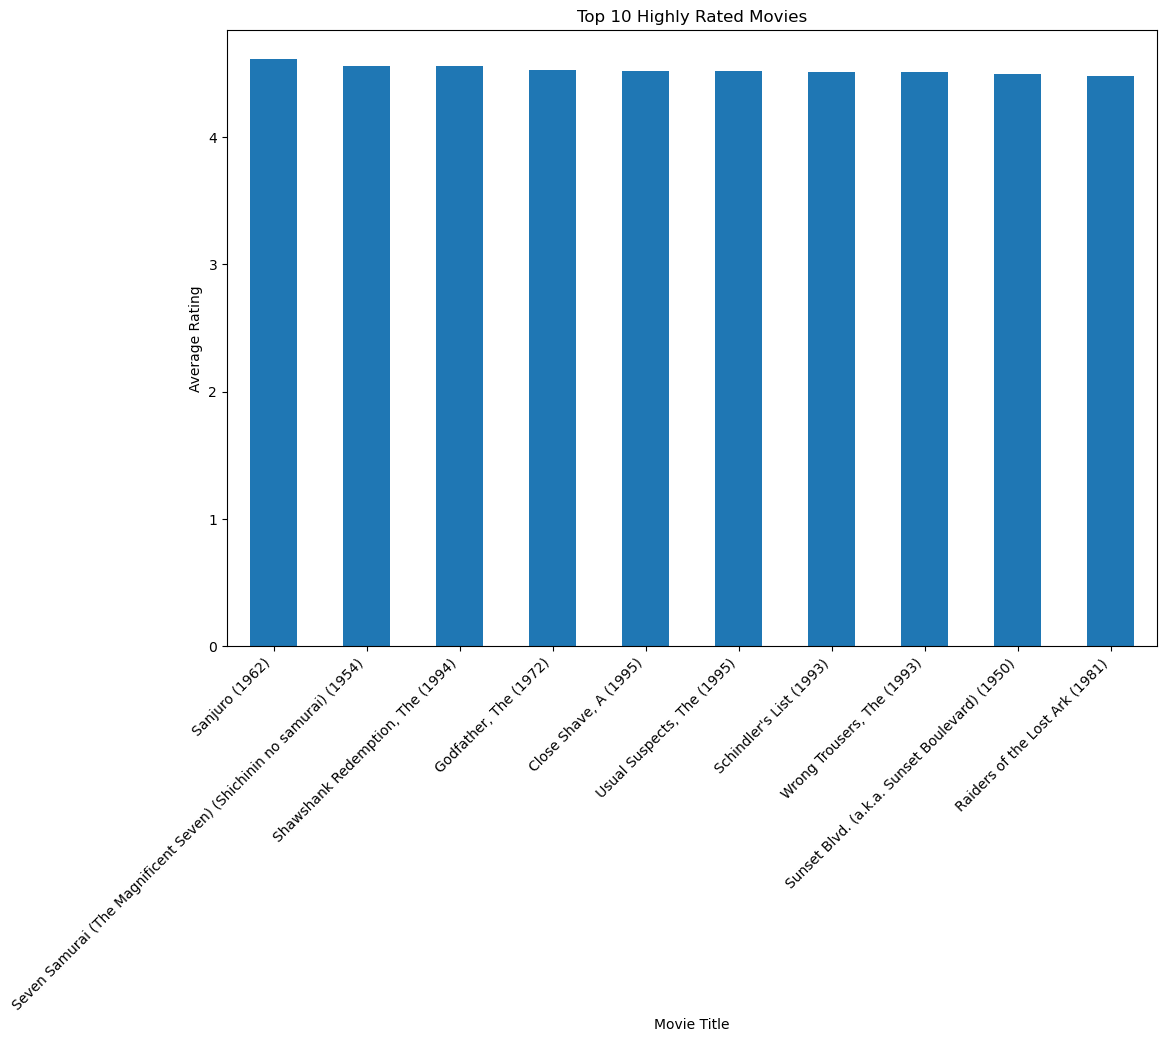

In [167]:
# Calculate the average rating for each movie
average_ratings = df_cleaned.groupby('Title')['Rating'].mean().sort_values(ascending=False).head(10)

# Plot the top 10 highly rated movies
plt.figure(figsize=(12, 8))
average_ratings.plot(kind='bar')
plt.xlabel('Movie Title')
plt.ylabel('Average Rating')
plt.title('Top 10 Highly Rated Movies')
plt.xticks(rotation=45, ha='right')
plt.show()

In [168]:
# Install the wordcloud library
# !pip install wordcloud

from wordcloud import WordCloud

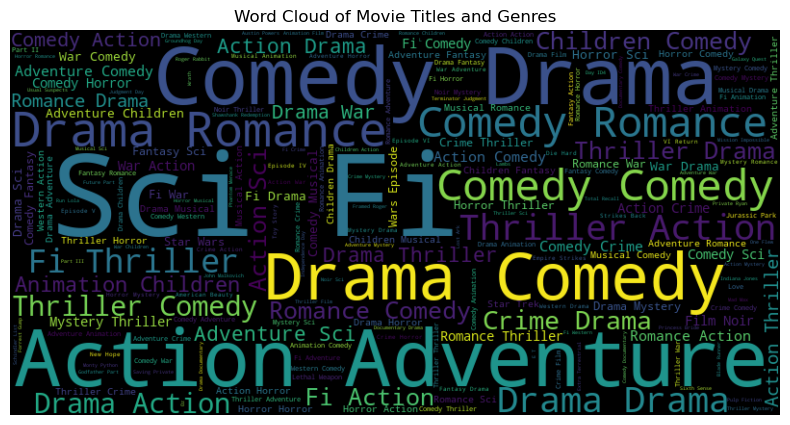

In [169]:
# Assuming df_cleaned is your DataFrame with 'Title' and 'Genres' columns

# Convert all elements in 'Genres' to strings if they are lists
def convert_genres(genres):
    if isinstance(genres, list):
        return ' '.join(genres)
    return str(genres)

df_cleaned['Genres'] = df_cleaned['Genres'].apply(convert_genres)

# Combine all movie titles and genres into a single string
all_titles = ' '.join(df_cleaned['Title'].astype(str))
all_genres = ' '.join(df_cleaned['Genres'])

# Combine titles and genres
combined_text = all_titles + ' ' + all_genres

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(combined_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Titles and Genres')
plt.show()

# Task 1: kNN-based Collaborative Filtering


In [170]:
# from sklearn.impute import KNNImputer
# import numpy as np
# import pandas as pd
# from sklearn.neighbors import NearestNeighbors
# from surprise import accuracy

# # Prepare the data without filling missing ratings with 0
# user_movie_ratings = df_cleaned.pivot(index='UserID', columns='Title', values='Rating')

# # Step 1: Apply KNN Imputer to fill missing values
# imputer = KNNImputer(n_neighbors=5, metric='nan_euclidean')
# user_movie_ratings_filled = pd.DataFrame(imputer.fit_transform(user_movie_ratings),
#                                          index=user_movie_ratings.index,
#                                          columns=user_movie_ratings.columns)



# # Now, use the filled ratings for your KNN-based prediction

# def apply_floor_rounding(rating):
#     """Take the integer part of the rating."""
#     return np.floor(rating)

# def predict_ratings(user_movie_ratings, user_index, k, metric):
#     model_knn = NearestNeighbors(metric=metric, algorithm='auto')
    
#     # Step 2: Fit the KNN model using the dataframe after KNN imputation
#     model_knn.fit(user_movie_ratings_filled)
    
#     # Find the k nearest neighbors
#     distances, indices = model_knn.kneighbors(user_movie_ratings_filled.iloc[[user_index]], n_neighbors=k+1)
#     similarities = 1 - distances.flatten()

#     # Get the neighbor's ratings (valid ones)
#     user_ratings = user_movie_ratings_filled.iloc[indices.flatten()[1:], :].copy()
    
#     # Apply similarity-based weighted sum
#     weighted_sum = np.nansum(similarities[1:, None] * user_ratings, axis=0)
#     sum_of_weights = np.nansum(similarities[1:, None] * user_ratings.notna(), axis=0)

#     # Predict ratings by dividing the weighted sum by the sum of weights
#     with np.errstate(divide='ignore', invalid='ignore'):
#         predicted_ratings = np.divide(weighted_sum, sum_of_weights, where=sum_of_weights != 0)
#     predicted_ratings[sum_of_weights == 0] = np.nan

#     # Apply floor rounding (take the integer part)
#     final_predictions = pd.Series(predicted_ratings, index=user_movie_ratings.columns)
#     final_predictions = final_predictions.apply(apply_floor_rounding)

#     return final_predictions

# # Randomly choose one user as the test set with random state 42
# np.random.seed(42)
# test_user_index = np.random.choice(user_movie_ratings.index)
# true_ratings = user_movie_ratings.loc[test_user_index, :]

# # Evaluate the impact of different k values and similarity metrics
# k_values = [5, 10, 15, 20, 25]
# similarity_metrics = ['cosine', 'euclidean']
# results = {}

# # Loop through all k values and similarity metrics and ensure everything is printed
# for metric in similarity_metrics:
#     for k in k_values:
#         predicted_ratings = predict_ratings(user_movie_ratings, test_user_index, k, metric)

#         # Filter out movies the user hasn't rated (apply the same mask to true and predicted ratings)
#         mask = true_ratings.notna()  # Mask to filter movies the user has rated
#         true_ratings_filtered = true_ratings[mask].values
#         predicted_ratings_filtered = predicted_ratings.reindex(true_ratings.index)[mask]  # Align indices and apply mask

#         # Inspect the true and predicted ratings for this user
#         print(f"\nInspecting predictions for Metric: {metric}, k: {k}")
#         print("True ratings (first 10):", true_ratings_filtered[:10])
#         print("Predicted ratings (first 10):", predicted_ratings_filtered[:10])

#         # Calculate RMSE
#         rmse = accuracy.rmse(true_ratings_filtered, predicted_ratings_filtered)
#         results[(metric, k)] = rmse
#         print(f"Metric: {metric}, k: {k}, RMSE: {rmse}")

# # Output the full results for all k values and metrics
# print("\nFinal RMSE Results:")
# for (metric, k), rmse in results.items():
#     print(f"Metric: {metric}, k: {k}, RMSE: {rmse}")

# # Find the optimal k and similarity metric
# optimal_metric, optimal_k = min(results, key=results.get)
# print(f"\nOptimal Metric: {optimal_metric}, Optimal k: {optimal_k}, RMSE: {results[(optimal_metric, optimal_k)]}")


In [171]:
from sklearn.impute import KNNImputer
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from surprise import accuracy

# Prepare the data without filling missing ratings with 0
user_movie_ratings = df_cleaned.pivot(index='UserID', columns='Title', values='Rating')

# Step 1: Apply KNN Imputer to fill missing values
imputer = KNNImputer(n_neighbors=5, metric='nan_euclidean')
user_movie_ratings_filled = pd.DataFrame(imputer.fit_transform(user_movie_ratings),
                                         index=user_movie_ratings.index,
                                         columns=user_movie_ratings.columns)

# Function to apply floor rounding
def apply_floor_rounding(rating):
    """Take the integer part of the rating."""
    return np.floor(rating)

# Function to predict ratings using kNN for a given user
def predict_ratings(user_movie_ratings_filled, user_index, k, metric):
    model_knn = NearestNeighbors(metric=metric, algorithm='auto')
    
    # Step 2: Fit the KNN model using the dataframe after KNN imputation (excluding the test user)
    model_knn.fit(user_movie_ratings_filled.drop(index=user_index))
    
    # Find the k nearest neighbors for the test user
    distances, indices = model_knn.kneighbors(user_movie_ratings_filled.iloc[[user_index]], n_neighbors=k+1)
    similarities = 1 - distances.flatten()

    # Get the neighbor's ratings (valid ones)
    user_ratings = user_movie_ratings_filled.iloc[indices.flatten()[1:], :].copy()
    
    # Apply similarity-based weighted sum
    weighted_sum = np.nansum(similarities[1:, None] * user_ratings, axis=0)
    sum_of_weights = np.nansum(similarities[1:, None] * user_ratings.notna(), axis=0)

    # Predict ratings by dividing the weighted sum by the sum of weights
    with np.errstate(divide='ignore', invalid='ignore'):
        predicted_ratings = np.divide(weighted_sum, sum_of_weights, where=sum_of_weights != 0)
    predicted_ratings[sum_of_weights == 0] = np.nan

    # Apply floor rounding (take the integer part)
    final_predictions = pd.Series(predicted_ratings, index=user_movie_ratings.columns)
    final_predictions = final_predictions.apply(apply_floor_rounding)

    return final_predictions

# Randomly choose one user as the test set with random state 42
np.random.seed(42)
test_user_index = np.random.choice(user_movie_ratings.index)
true_ratings = user_movie_ratings.loc[test_user_index, :]

# Evaluate the impact of different k values and similarity metrics
k_values = [5, 10, 15, 20, 25]
similarity_metrics = ['cosine', 'euclidean']
results = {}

# Loop through all k values and similarity metrics and ensure everything is printed
for metric in similarity_metrics:
    for k in k_values:
        # Predict ratings for the test user
        predicted_ratings = predict_ratings(user_movie_ratings_filled, test_user_index, k, metric)

        # Filter out movies the test user hasn't rated (apply the same mask to true and predicted ratings)
        mask = true_ratings.notna()  # Mask to filter movies the test user has rated
        true_ratings_filtered = true_ratings[mask].values
        predicted_ratings_filtered = predicted_ratings.reindex(true_ratings.index)[mask]  # Align indices and apply mask

        # Construct the list of predictions in the format expected by Surprise's rmse
        predictions = []
        for movie_id, (true_rating, predicted_rating) in zip(true_ratings.index[mask], zip(true_ratings_filtered, predicted_ratings_filtered)):
            if not np.isnan(true_rating) and not np.isnan(predicted_rating):  # Ensure we only include valid ratings
                predictions.append((test_user_index, movie_id, true_rating, predicted_rating, None))  # Format expected by Surprise

        # Use Surprise's RMSE calculation
        rmse = accuracy.rmse(predictions, verbose=False)
        results[(metric, k)] = rmse

        # Inspect the true and predicted ratings for this user
        print(f"\nInspecting predictions for Metric: {metric}, k: {k}")
        print("True ratings (first 10):", true_ratings_filtered[:10])
        print("Predicted ratings (first 10):", predicted_ratings_filtered[:10])
        print(f"Metric: {metric}, k: {k}, RMSE: {rmse}")

# Output the full results for all k values and metrics
print("\nFinal RMSE Results:")
for (metric, k), rmse in results.items():
    print(f"Metric: {metric}, k: {k}, RMSE: {rmse}")

# Find the optimal k and similarity metric
optimal_metric, optimal_k = min(results, key=results.get)
print(f"\nOptimal Metric: {optimal_metric}, Optimal k: {optimal_k}, RMSE: {results[(optimal_metric, optimal_k)]}")



Inspecting predictions for Metric: cosine, k: 5
True ratings (first 10): [4. 5. 5. 4. 5. 4. 4. 5. 4. 4.]
Predicted ratings (first 10): Title
Adventures in Babysitting (1987)      3.0
Airplane! (1980)                      4.0
Arthur (1981)                         3.0
Babe (1995)                           4.0
Back to the Future (1985)             3.0
Back to the Future Part II (1989)     3.0
Being John Malkovich (1999)           4.0
Better Off Dead... (1985)             4.0
Big (1988)                            4.0
Big Trouble in Little China (1986)    3.0
dtype: float64
Metric: cosine, k: 5, RMSE: 1.1346805717910218

Inspecting predictions for Metric: cosine, k: 10
True ratings (first 10): [4. 5. 5. 4. 5. 4. 4. 5. 4. 4.]
Predicted ratings (first 10): Title
Adventures in Babysitting (1987)      3.0
Airplane! (1980)                      3.0
Arthur (1981)                         3.0
Babe (1995)                           3.0
Back to the Future (1985)             4.0
Back to the Future Part

In [172]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from surprise import accuracy

# Prepare the data without filling missing ratings with 0
user_movie_ratings = df_cleaned.pivot(index='UserID', columns='Title', values='Rating')

# Prepare the data by filling missing ratings with the global mean
global_mean = user_movie_ratings.mean().mean()
user_movie_ratings_filled = user_movie_ratings.fillna(global_mean)


In [173]:
user_movie_ratings_filled

Title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)",...,Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zeus and Roxanne (1997),eXistenZ (1999)
UserID,,,,,,,,,,,,,,,,,,,,,
1,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,...,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105
2,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,...,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105
3,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,...,5.000000,4.000000,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105
4,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,...,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105
5,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,...,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,3.285105,3.000000,3.285105,3.285105,3.285105,2.000000,4.000000,3.285105,3.285105,1.000000,...,3.285105,3.285105,3.285105,3.000000,3.285105,3.285105,3.285105,3.285105,3.285105,2.000000
6037,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,4.000000,3.285105,...,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105
6038,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,...,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105,3.285105


In [ ]:
from surprise import Dataset, Reader
from surprise.model_selection import RandomizedSearchCV
from surprise import KNNBasic
import numpy as np
import pandas as pd

# Prepare data for Surprise
def prepare_surprise_data(df):
    df_surprise = df.stack().reset_index()
    df_surprise.columns = ['UserID', 'Title', 'Rating']
    return df_surprise

# Convert data into Surprise format
df_surprise = prepare_surprise_data(user_movie_ratings_filled)

# Step 1: Create Surprise Dataset
reader = Reader(rating_scale=(user_movie_ratings_filled.min().min(), user_movie_ratings_filled.max().max()))
data = Dataset.load_from_df(df_surprise[['UserID', 'Title', 'Rating']], reader)

# Randomly choose one user as the test set
np.random.seed(42)
test_user = np.random.choice(user_movie_ratings_filled.index)

# Prepare the train and test sets manually
train_df = df_surprise[df_surprise['UserID'] != test_user]  # All users except the test user
test_df = df_surprise[df_surprise['UserID'] == test_user]   # Only the test user

# Convert the test and train data into Surprise trainset and testset formats
trainset = Dataset.load_from_df(train_df[['UserID', 'Title', 'Rating']], reader).build_full_trainset()

# Define parameter grid
param_grid = {
    'k': np.arange(5, 30, 5),
    'sim_options': {
        'name': ['cosine', 'pearson_baseline'],
        'user_based': [True]  # Keep user-user similarity
    }
}

# Step 2: Initialize RandomizedSearchCV
algo = KNNBasic
random_search = RandomizedSearchCV(algo, param_grid, n_iter=10, measures=['rmse'], cv=10)

# Step 3: Perform the random search on training data
random_search.fit(data)

# Step 4: Get best RMSE score and corresponding hyperparameters
print("Best RMSE score: ", random_search.best_score['rmse'])
print("Best hyperparameters: ", random_search.best_params['rmse'])


# Task 2: Matrix Factorization-based Recommendation

In [23]:
def feature_selection(df):
    keep_cols = ['UserID','MovieID','Rating']
    for i in df.columns:
        if i not in keep_cols:
            df.drop(i, inplace = True, axis = 1)
    return df

In [24]:
# !pip install scikit-surprise

In [47]:
# Import necessary libraries
import pandas as pd
import numpy as np
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split


In [48]:
df_selected = pd.read_csv('./cleaned_data.csv')

/tmp/ipykernel_1663220/1966943147.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_selected = pd.read_csv('./cleaned_data.csv')


In [49]:
# Calculate global mean
global_mean = round(df_selected['Rating'].mean())

# Fill missing ratings with the mean rating for each user
df_selected['Rating'] = df_selected.groupby('UserID')['Rating'].transform(lambda x: x.fillna(round(x.mean())))

# For users who have no ratings, fall back to global mean
df_selected['Rating'].fillna(global_mean, inplace=True)

df_filled = df_selected.copy()

/tmp/ipykernel_1663220/110346395.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_selected['Rating'].fillna(global_mean, inplace=True)


In [50]:
c

In [73]:
# Step 3: Prepare the dataset for surprise
# Use Reader to define the rating scale (in this case, 0-5)
reader = Reader(rating_scale=(0, 5))

# Load the training data for surprise
train_data = Dataset.load_from_df(train_df[['UserID', 'MovieID', 'Rating']], reader)

# Build the full trainset from the training data
trainset = train_data.build_full_trainset()

# Step 4: Train the SVD algorithm
algo = SVD()
algo.fit(trainset)

# Step 5: Predict ratings for the test set
predictions = []

for index, row in test_df.iterrows():
    user_id = row['UserID']
    movie_id = row['MovieID']
    true_rating = row['Rating']
    
    # Predict the rating for the user-movie pair
    pred = algo.predict(user_id, movie_id, r_ui=true_rating)
    predictions.append(pred)

In [74]:
# Step 6: Evaluate the model using RMSE
from surprise import accuracy
rmse_baseline = accuracy.rmse(predictions)
print(f"RMSE: {rmse_baseline:.4f}")

RMSE: 1.1012
RMSE: 1.1012


In [75]:
# Step 5: Hyperparameter tuning using RandomizedSearchCV
from surprise.model_selection import RandomizedSearchCV
param_dist = {
    'n_factors': [10, 20, 50, 100],         # Number of latent factors
    'n_epochs': [10, 20, 30, 40],           # Number of training epochs
    'lr_all': [0.002, 0.005, 0.01, 0.02],   # Learning rate for SGD
    'reg_all': [0.02, 0.05, 0.1, 0.2]       # Regularization term
}

# Perform random search with 10 iterations
rs = RandomizedSearchCV(SVD, param_dist, measures=['rmse'], cv=3, n_iter=10, random_state=42)
# rs.fit(train_data)

# # Step 6: Best model from RandomizedSearchCV
# best_params = rs.best_params['rmse']
# print(f"Best Parameters from Randomized Search: {best_params}")


In [76]:
# Step 6: Best model from RandomizedSearchCV
best_params = {'n_factors': 20, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.02}
print(f"Best Parameters from Randomized Search: {best_params}")

Best Parameters from Randomized Search: {'n_factors': 20, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.02}


In [77]:
best_params

{'n_factors': 20, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.02}

In [78]:
# Train SVD with the best parameters
algo_tuned = SVD(n_factors=best_params['n_factors'], n_epochs=best_params['n_epochs'],
                 lr_all=best_params['lr_all'], reg_all=best_params['reg_all'])
algo_tuned.fit(trainset)

# Predict ratings for the test set using the tuned model
predictions_tuned = []
for index, row in test_df.iterrows():
    user_id = row['UserID']
    movie_id = row['MovieID']
    true_rating = row['Rating']
    pred = algo_tuned.predict(user_id, movie_id, r_ui=true_rating)
    predictions_tuned.append(pred)

# Evaluate the tuned SVD model
rmse_tuned = accuracy.rmse(predictions_tuned)
print(f"Tuned RMSE: {rmse_tuned:.4f}")

# Step 7: Compare baseline and tuned RMSE
print(f"Improvement: {rmse_baseline - rmse_tuned:.4f} RMSE reduction")

RMSE: 1.1121
Tuned RMSE: 1.1121
Improvement: -0.0109 RMSE reduction


## SVD + Catboost

In [57]:
# !pip install catboost

In [65]:
train_cols = ['Action','Age','Occupation', 'Adventure',
       'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western','Gender_F', 'Gender_M']

In [64]:
train_df = pd.get_dummies(train_df, columns=['Gender'])
test_df = pd.get_dummies(test_df, columns=['Gender'])

In [82]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from catboost import CatBoostRegressor

# Step 1: Load and prepare the Surprise dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_filled[['UserID', 'MovieID', 'Rating']], reader)
trainset = data.build_full_trainset()

# Step 2: Train SVD model
svd_model = SVD()
svd_model.fit(trainset)

# Step 3: Extract latent features for users and items
train_df['user_latent'] = train_df['UserID'].apply(lambda x: svd_model.pu[trainset.to_inner_uid(x)])
train_df['item_latent'] = train_df['MovieID'].apply(lambda x: svd_model.qi[trainset.to_inner_iid(x)])

# Reset index and rename latent columns to avoid duplicates
train_df.reset_index(drop=True, inplace=True)

# Convert latent features to DataFrames with custom column names to avoid conflicts
user_latent_df = pd.DataFrame(train_df['user_latent'].to_list(), columns=[f'user_latent_{i}' for i in range(len(train_df['user_latent'][0]))])
item_latent_df = pd.DataFrame(train_df['item_latent'].to_list(), columns=[f'item_latent_{i}' for i in range(len(train_df['item_latent'][0]))])

# Step 4: Prepare CatBoost data
# Concatenate the latent factors with other metadata (e.g., Gender, Age, Occupation, Genres)
X_train = pd.concat([user_latent_df, item_latent_df,
                     train_df[train_cols].reset_index(drop=True)], axis=1)


# Ensure no NaN values in the data
X_train.fillna(0, inplace=True)

In [83]:
# Ensure unique column names
X_train.columns = [f'feature_{i}' if col == '' else col for i, col in enumerate(X_train.columns)]
X_train = X_train.astype(float)
y_train = train_df['Rating']

In [84]:
# Step 5: Train CatBoost model
catboost_model = CatBoostRegressor(iterations=25000, learning_rate=0.01, depth=6, task_type = 'GPU')
catboost_model.fit(X_train, y_train)  # categorical features

0:	learn: 1.1151084	total: 21.1ms	remaining: 8m 48s
1:	learn: 1.1138396	total: 40.3ms	remaining: 8m 24s
2:	learn: 1.1126025	total: 59.1ms	remaining: 8m 12s
3:	learn: 1.1113782	total: 78.3ms	remaining: 8m 9s
4:	learn: 1.1101513	total: 96.9ms	remaining: 8m 4s
5:	learn: 1.1089588	total: 115ms	remaining: 7m 59s
6:	learn: 1.1077722	total: 134ms	remaining: 7m 57s
7:	learn: 1.1066176	total: 153ms	remaining: 7m 56s
8:	learn: 1.1054334	total: 171ms	remaining: 7m 54s
9:	learn: 1.1042922	total: 188ms	remaining: 7m 50s
10:	learn: 1.1031646	total: 206ms	remaining: 7m 49s
11:	learn: 1.1020784	total: 225ms	remaining: 7m 48s
12:	learn: 1.1010022	total: 244ms	remaining: 7m 48s
13:	learn: 1.0999434	total: 262ms	remaining: 7m 47s
14:	learn: 1.0988927	total: 280ms	remaining: 7m 46s
15:	learn: 1.0978546	total: 298ms	remaining: 7m 45s
16:	learn: 1.0968179	total: 315ms	remaining: 7m 43s
17:	learn: 1.0958273	total: 333ms	remaining: 7m 41s
18:	learn: 1.0948321	total: 350ms	remaining: 7m 40s
19:	learn: 1.093846

In [85]:
# Step 6: Extract latent features for test data using SVD
# Handle unseen items by assigning a default value if an item was not part of the trainset
def get_item_latent_factors(item_id):
    try:
        return svd_model.qi[trainset.to_inner_iid(item_id)]
    except ValueError:
        # Return a vector of zeros or an average latent factor for unseen items
        return np.zeros(svd_model.qi.shape[1])  # shape[1] returns the number of latent factors

# Extract latent features for test data using SVD
test_df['user_latent'] = test_df['UserID'].apply(lambda x: svd_model.pu[trainset.to_inner_uid(x)])
test_df['item_latent'] = test_df['MovieID'].apply(get_item_latent_factors)

# Reset index and rename latent columns for test data
test_df.reset_index(drop=True, inplace=True)

# Prepare the test set for CatBoost
user_latent_test_df = pd.DataFrame(test_df['user_latent'].to_list(), columns=[f'user_latent_{i}' for i in range(len(test_df['user_latent'][0]))])
item_latent_test_df = pd.DataFrame(test_df['item_latent'].to_list(), columns=[f'item_latent_{i}' for i in range(len(test_df['item_latent'][0]))])

X_test = pd.concat([user_latent_test_df, item_latent_test_df,
                    test_df[train_cols].reset_index(drop=True)], axis=1)

# Ensure no NaN values in the test data
X_test.fillna(0, inplace=True)

# Ensure unique column names for test set
X_test.columns = [f'feature_{i}' if col == '' else col for i, col in enumerate(X_test.columns)]

# Step 8: Predict ratings
predictions = np.round(catboost_model.predict(X_test)).astype(int)

In [86]:
from sklearn.metrics import mean_squared_error

# Step 9: Calculate RMSE
true_ratings = test_df['Rating']  # The actual ratings in the test set
predicted_ratings = predictions  # The predicted ratings from CatBoost

# Calculate the RMSE
rmse_svd_catboost = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))

print(f"RMSE: {rmse_svd_catboost}")

RMSE: 0.851070350918998


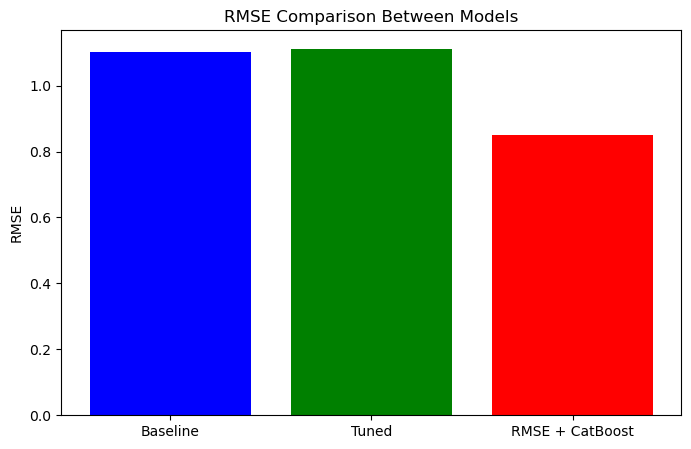

In [87]:
import matplotlib.pyplot as plt

# RMSE values for the models
models = ['Baseline', 'Tuned', 'RMSE + CatBoost']
rmse_values = [rmse_baseline, rmse_tuned, rmse_svd_catboost]

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.bar(models, rmse_values, color=['blue', 'green', 'red'])
plt.ylabel('RMSE')
plt.title('RMSE Comparison Between Models')
plt.show()

# Task 3: Ranking-based Evaluation and Comparison

In [51]:
def feature_selection(df):
    keep_cols = ['UserID','MovieID','Title','Rating']
    for i in df.columns:
        if i not in keep_cols:
            df.drop(i, inplace = True, axis = 1)
    return df

In [135]:
df_filled = pd.read_csv('filled_data.csv')
df_filled  = pd.get_dummies(df_filled,  columns=['Gender'])
df_filled_selected = feature_selection(df_filled.copy())

/tmp/ipykernel_1663220/1879491118.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_filled = pd.read_csv('filled_data.csv')


In [119]:
import pandas as pd
from surprise import Dataset, Reader, KNNBasic
import numpy as np

# Define a Reader object for Surprise
reader = Reader(rating_scale=(1, 5))

# Convert the data to the Surprise format
data = Dataset.load_from_df(df_filled_selected[['UserID', 'MovieID','Rating']], reader)

# Get users who have rated more than 100 movies
user_ratings_count = df_filled_selected.groupby('UserID')['MovieID'].count()
eligible_users = user_ratings_count[user_ratings_count > 100].index

# Randomly select 10 users from eligible users as the test set
random_users = np.random.choice(eligible_users, size=10, replace=False)

# Split the data into training and test sets manually
train_df = df_filled_selected[~df_filled_selected['UserID'].isin(random_users)]  # Exclude test users from training set
test_df = df_filled_selected[df_filled_selected['UserID'].isin(random_users)]  # Include only the test users

# Create a lookup dictionary for MovieID -> MovieTitle
movie_id_to_title = df_filled_selected[['MovieID', 'Title']].drop_duplicates().set_index('MovieID')['Title'].to_dict()

### Basic SVD

In [120]:

# Convert the training data into the Surprise format
train_data = Dataset.load_from_df(train_df[['UserID', 'MovieID', 'Rating']], reader)
trainset = train_data.build_full_trainset()

# Train a KNN-based collaborative filtering model
sim_options = {'name': 'cosine', 'user_based': True}
model = KNNBasic(sim_options=sim_options)
model.fit(trainset)

# Prepare the testset in Surprise format: list of (user_id, movie_id, actual_rating) for all users in testset
testset = [tuple(x) for x in test_df[['UserID', 'MovieID', 'Rating']].values]

# Predict ratings for the test set users (test predictions)
test_predictions = model.test(testset)

# Use the lookup dictionary to add movie titles to the predictions
predictions_list = []
for uid, iid, true_r, est, _ in test_predictions:
    movie_title = movie_id_to_title.get(iid, "Unknown Title")
    predictions_list.append({'UserID': uid, 'MovieID': iid, 'Title': movie_title, 'TrueRating': true_r, 'EstimatedRating': est})

# Convert the list to a DataFrame and save to a CSV file for later evaluation
predictions_df = pd.DataFrame(predictions_list)
predictions_df.to_csv('saved_test_predictions_with_titles.csv', index=False)

print("Test predictions saved to 'saved_test_predictions_with_titles.csv'")

# Function to get top-n recommendations for selected users based on the test predictions
def get_top_n_recommendations(predictions, n=20):
    # Map the predictions to each user
    top_n = {}
    for uid, iid, true_r, est, _ in predictions:
        movie_title = movie_id_to_title.get(iid, "Unknown Title")
        if uid not in top_n:
            top_n[uid] = []
        top_n[uid].append((iid, movie_title, est))

    # For each user, sort the predictions by the estimated rating
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[2], reverse=True)
        top_n[uid] = [(iid, movie_title) for (iid, movie_title, _) in user_ratings[:n]]
    
    return top_n

# Get top-20 recommendations for the test set users
top_20_recommendations = get_top_n_recommendations(test_predictions, n=20)

# Display recommendations for each test user
for user, movies in top_20_recommendations.items():
    print(f"Top 20 recommendations for User {user}:")
    for movie_id, movie_title in movies:
        print(f"MovieID: {movie_id}, MovieTitle: {movie_title}")


Computing the cosine similarity matrix...
Done computing similarity matrix.
Test predictions saved to 'saved_test_predictions_with_titles.csv'
Top 20 recommendations for User 59.0:
MovieID: 1175.0, MovieTitle: Delicatessen (1991)
MovieID: 1249.0, MovieTitle: Nikita (La Femme Nikita) (1990)
MovieID: 1250.0, MovieTitle: Bridge on the River Kwai, The (1957)
MovieID: 1251.0, MovieTitle: 8 1/2 (1963)
MovieID: 1252.0, MovieTitle: Chinatown (1974)
MovieID: 1254.0, MovieTitle: Treasure of the Sierra Madre, The (1948)
MovieID: 1183.0, MovieTitle: English Patient, The (1996)
MovieID: 650.0, MovieTitle: Moll Flanders (1996)
MovieID: 2997.0, MovieTitle: Being John Malkovich (1999)
MovieID: 1188.0, MovieTitle: Strictly Ballroom (1992)
MovieID: 3871.0, MovieTitle: Shane (1953)
MovieID: 2065.0, MovieTitle: Purple Rose of Cairo, The (1985)
MovieID: 2067.0, MovieTitle: Doctor Zhivago (1965)
MovieID: 1265.0, MovieTitle: Groundhog Day (1993)
MovieID: 1266.0, MovieTitle: Unforgiven (1992)
MovieID: 1193.0,

In [94]:
df_result = pd.read_csv('saved_test_predictions_with_titles.csv')
df_result.head()


,UserID,MovieID,Title,TrueRating,EstimatedRating
0,549.0,2987.0,Who Framed Roger Rabbit? (1988),4.0,3.582037
1,549.0,1248.0,Touch of Evil (1958),3.0,3.582037
2,549.0,1249.0,Nikita (La Femme Nikita) (1990),5.0,3.582037
3,549.0,2989.0,For Your Eyes Only (1981),4.0,3.582037
4,549.0,3932.0,"Invisible Man, The (1933)",5.0,3.582037


In [121]:
import pandas as pd
from surprise import accuracy
from surprise import Prediction

# Load the saved predictions from the CSV file
predictions_df = pd.read_csv('saved_test_predictions_with_titles.csv')

# Convert the DataFrame into a list of Surprise Prediction objects
test_predictions = [
    Prediction(uid=row['UserID'], iid=row['MovieID'], r_ui=row['TrueRating'], est=row['EstimatedRating'], details={})
    for _, row in predictions_df.iterrows()
]

# Calculate RMSE from the loaded predictions
rmse_value = accuracy.rmse(test_predictions)

print(f"RMSE on the test set: {rmse_value}")

RMSE: 1.0888
RMSE on the test set: 1.0887676529857855


In [122]:
import pandas as pd
from surprise import Prediction
from sklearn.metrics import average_precision_score, ndcg_score

# Load the saved predictions from the CSV file
predictions_df = pd.read_csv('saved_test_predictions_with_titles.csv')

# Convert the DataFrame into a list of Surprise Prediction objects
test_predictions = [
    Prediction(uid=row['UserID'], iid=row['MovieID'], r_ui=row['TrueRating'], est=row['EstimatedRating'], details={})
    for _, row in predictions_df.iterrows()
]

# Prepare the true and predicted labels for each user
def get_true_and_pred_labels(test_predictions, threshold=4.0):
    y_true = {}  # True binary relevance (1 if rating >= threshold)
    y_score = {}  # Predicted relevance scores (estimated ratings)
    
    for pred in test_predictions:
        uid = pred.uid
        if uid not in y_true:
            y_true[uid] = []
            y_score[uid] = []
        # True relevance (1 if true rating >= threshold, otherwise 0)
        y_true[uid].append(1 if pred.r_ui >= threshold else 0)
        # Estimated score (predicted rating)
        y_score[uid].append(pred.est)
    
    return y_true, y_score

# Get true binary relevance and predicted relevance scores
y_true, y_score = get_true_and_pred_labels(test_predictions, threshold=4.0)

# Compute Average Precision (AP) and NDCG for each user
average_precisions = []
ndcgs = []
for uid in y_true:
    ap = average_precision_score(y_true[uid], y_score[uid])  # Average Precision
    ndcg = ndcg_score([y_true[uid]], [y_score[uid]])  # NDCG
    
    average_precisions.append(ap)
    ndcgs.append(ndcg)

# Calculate the mean AP and NDCG
mean_ap = sum(average_precisions) / len(average_precisions)
mean_ndcg = sum(ndcgs) / len(ndcgs)

print(f"Mean Average Precision (mAP): {mean_ap}")


print(f"Mean NDCG: {mean_ndcg}")


Mean Average Precision (mAP): 0.5403335515375505
Mean NDCG: 0.8387939159331712


## SVD + Catboost

In [137]:
# Step 6: Split the data into training and test sets manually
train_df = df_filled[~df_filled['UserID'].isin(random_users)]  # Exclude test users from training set
test_df = df_filled[df_filled['UserID'].isin(random_users)]  # Include only the test users

In [138]:
train_cols = ['Action','Age','Occupation', 'Adventure',
       'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western','Gender_F', 'Gender_M']

In [139]:
train_df.columns

Index(['UserID', 'Age', 'Occupation', 'Zip-code', 'MovieID', 'Rating',
       'Timestamp', 'Title', 'Genres', 'Action', 'Adventure', 'Animation',
       'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western', 'Gender_F', 'Gender_M'],
      dtype='object')

In [140]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, ndcg_score, average_precision_score

# Assuming df_filled is your dataset and contains the columns ['UserID', 'MovieID', 'Rating', 'Gender', 'Age', 'Occupation', 'Genres']

# Step 1: Load and prepare the Surprise dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_filled[['UserID', 'MovieID', 'Rating']], reader)
trainset = data.build_full_trainset()

# Step 2: Train SVD model
svd_model = SVD()
svd_model.fit(trainset)

# Step 3: Extract latent features for users and items
train_df['user_latent'] = train_df['UserID'].apply(lambda x: svd_model.pu[trainset.to_inner_uid(x)])
train_df['item_latent'] = train_df['MovieID'].apply(lambda x: svd_model.qi[trainset.to_inner_iid(x)])

# Reset index and rename latent columns to avoid duplicates
train_df.reset_index(drop=True, inplace=True)

# Convert latent features to DataFrames with custom column names to avoid conflicts
user_latent_df = pd.DataFrame(train_df['user_latent'].to_list(), columns=[f'user_latent_{i}' for i in range(len(train_df['user_latent'][0]))])
item_latent_df = pd.DataFrame(train_df['item_latent'].to_list(), columns=[f'item_latent_{i}' for i in range(len(train_df['item_latent'][0]))])

# Step 7: Prepare CatBoost data
X_train = pd.concat([user_latent_df, item_latent_df, train_df[train_cols].reset_index(drop=True)], axis=1)

# Ensure no NaN values in the data
X_train.fillna(0, inplace=True)
X_train = X_train.astype(float)
y_train = train_df['Rating']

# Step 8: Train CatBoost model
catboost_model = CatBoostRegressor(iterations=25000, learning_rate=0.01, depth=6, verbose=False, task_type='GPU')
catboost_model.fit(X_train, y_train)


# Step 12: Compute NDCG and AP for each user using sklearn

/tmp/ipykernel_1663220/3163330372.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['user_latent'] = train_df['UserID'].apply(lambda x: svd_model.pu[trainset.to_inner_uid(x)])
/tmp/ipykernel_1663220/3163330372.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['item_latent'] = train_df['MovieID'].apply(lambda x: svd_model.qi[trainset.to_inner_iid(x)])


In [141]:

# Step 9: Handle unseen items by assigning a default value for latent factors
def get_item_latent_factors(item_id):
    try:
        return svd_model.qi[trainset.to_inner_iid(item_id)]
    except ValueError:
        # Return a vector of zeros for unseen items
        return np.zeros(svd_model.qi.shape[1])

# Extract latent features for test data using SVD
test_df['user_latent'] = test_df['UserID'].apply(lambda x: svd_model.pu[trainset.to_inner_uid(x)])
test_df['item_latent'] = test_df['MovieID'].apply(get_item_latent_factors)

# Reset index and rename latent columns for test data
test_df.reset_index(drop=True, inplace=True)

# Prepare the test set for CatBoost
user_latent_test_df = pd.DataFrame(test_df['user_latent'].to_list(), columns=[f'user_latent_{i}' for i in range(len(test_df['user_latent'][0]))])
item_latent_test_df = pd.DataFrame(test_df['item_latent'].to_list(), columns=[f'item_latent_{i}' for i in range(len(test_df['item_latent'][0]))])

X_test = pd.concat([user_latent_test_df, item_latent_test_df, test_df[train_cols].reset_index(drop=True)], axis=1)

# Ensure no NaN values in the test data
X_test.fillna(0, inplace=True)

# Step 10: Predict ratings with CatBoost
predictions = np.round(catboost_model.predict(X_test)).astype(int)

# Step 11: Calculate RMSE
true_ratings = test_df['Rating']  # The actual ratings in the test set
predicted_ratings = predictions  # The predicted ratings from CatBoost

rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
print(f"RMSE: {rmse}")


/tmp/ipykernel_1663220/3968282620.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['user_latent'] = test_df['UserID'].apply(lambda x: svd_model.pu[trainset.to_inner_uid(x)])
/tmp/ipykernel_1663220/3968282620.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['item_latent'] = test_df['MovieID'].apply(get_item_latent_factors)


RMSE: 0.7833494518006403


In [142]:
results = []
k = 20  # Setting k for NDCG@k and AP@k

for user_id, user_df in test_df.groupby('UserID'):
    # Sort by predicted ratings
    user_df['PredictedRating'] = predictions[test_df['UserID'] == user_id]
    user_df_sorted = user_df.sort_values(by='PredictedRating', ascending=False)

    # Binary relevance for NDCG and AP calculation (relevance: 1 if TrueRating >= 4, else 0)
    relevance = [1 if rating >= 4 else 0 for rating in user_df_sorted['Rating']]

    # Use sklearn's ndcg_score and average_precision_score
    true_relevance = np.asarray(relevance).reshape(1, -1)
    predicted_scores = np.asarray(user_df_sorted['PredictedRating']).reshape(1, -1)

    ndcg = ndcg_score(true_relevance, predicted_scores,k=k) 
    ap = average_precision_score(true_relevance.flatten(), predicted_scores.flatten())

    # Store results
    results.append({'UserID': user_id, 'NDCG@20': ndcg, 'AP@20': ap})

# Convert results to DataFrame and display/save
results_df = pd.DataFrame(results)
print(results_df)

   UserID   NDCG@20     AP@20
0      59  0.892755  0.704070
1     934  0.769879  0.621323
2    1685  0.906977  0.696115
3    2266  0.946690  0.862456
4    3159  1.000000  0.934241
5    3387  0.932345  0.779502
6    3414  1.000000  0.964528
7    3732  1.000000  0.813016
8    4965  0.909997  0.775564
9    5151  0.844177  0.711358


In [143]:
import pandas as pd
import numpy as np
from sklearn.metrics import ndcg_score, average_precision_score

results = []
k = 20  # Setting k for NDCG@k and AP@k

for user_id, user_df in test_df.groupby('UserID'):
    # Sort by predicted ratings
    user_df['PredictedRating'] = predictions[test_df['UserID'] == user_id]
    user_df_sorted = user_df.sort_values(by='PredictedRating', ascending=False)

    # Binary relevance for NDCG and AP calculation (relevance: 1 if TrueRating >= 4, else 0)
    relevance = [1 if rating >= 4 else 0 for rating in user_df_sorted['Rating']]

    # Use sklearn's ndcg_score and average_precision_score
    true_relevance = np.asarray(relevance).reshape(1, -1)
    predicted_scores = np.asarray(user_df_sorted['PredictedRating']).reshape(1, -1)

    ndcg = ndcg_score(true_relevance, predicted_scores,k=k) 
    ap = average_precision_score(true_relevance.flatten(), predicted_scores.flatten())

    # Store results
    results.append({'UserID': user_id, 'NDCG@20': ndcg, 'AP@20': ap})

# Convert results to DataFrame and display/save
results_df = pd.DataFrame(results)
print(results_df)

   UserID   NDCG@20     AP@20
0      59  0.892755  0.704070
1     934  0.769879  0.621323
2    1685  0.906977  0.696115
3    2266  0.946690  0.862456
4    3159  1.000000  0.934241
5    3387  0.932345  0.779502
6    3414  1.000000  0.964528
7    3732  1.000000  0.813016
8    4965  0.909997  0.775564
9    5151  0.844177  0.711358


In [144]:
average_ndcg_svd_catboost = results_df['NDCG@20'].mean()
average_ap_svd_catboost = results_df['AP@20'].mean()

# Print the averages
print(f"Average NDCG@20: {average_ndcg_svd_catboost}")
print(f"Average AP@20: {average_ap_svd_catboost}")

Average NDCG@20: 0.920281968767757
Average AP@20: 0.7862173668599073


In [145]:

# Step 13: Get top-N recommendations for selected users
def get_top_n_recommendations(predictions, n=20):
    top_n = {}
    for uid, movie_id, rating in zip(test_df['UserID'], test_df['MovieID'], predictions):
        if uid not in top_n:
            top_n[uid] = []
        movie_title = movie_id_to_title.get(movie_id, "Unknown Title")
        top_n[uid].append((movie_id, movie_title, rating))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[2], reverse=True)
        top_n[uid] = [(movie_id, movie_title) for (movie_id, movie_title, _) in user_ratings[:n]]
    
    return top_n

# Create a movie title lookup dictionary
movie_id_to_title = df_filled[['MovieID', 'Title']].drop_duplicates().set_index('MovieID')['Title'].to_dict()

# Get top 20 recommendations for the test set users
top_20_recommendations = get_top_n_recommendations(predictions, n=20)

recommendations_list = []
# Collecting recommendations for each user
for user, movies in top_20_recommendations.items():
    print(f"Top 20 recommendations for User {user}:")
    for movie_id, movie_title in movies:
        print(f"MovieID: {movie_id}, MovieTitle: {movie_title}")
        # Append the UserID, MovieID, and MovieTitle to the list
        recommendations_list.append({'UserID': user, 'MovieID': movie_id, 'MovieTitle': movie_title})

# Convert the list of recommendations to a DataFrame
recommendations_df = pd.DataFrame(recommendations_list)

# Save the DataFrame to a CSV file
recommendations_df.to_csv('top_20_recommendations_svd_catboost.csv', index=False)

Top 20 recommendations for User 59:
MovieID: 1947, MovieTitle: West Side Story (1961)
MovieID: 1183, MovieTitle: English Patient, The (1996)
MovieID: 1188, MovieTitle: Strictly Ballroom (1992)
MovieID: 2067, MovieTitle: Doctor Zhivago (1965)
MovieID: 750, MovieTitle: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)
MovieID: 902, MovieTitle: Breakfast at Tiffany's (1961)
MovieID: 903, MovieTitle: Vertigo (1958)
MovieID: 905, MovieTitle: It Happened One Night (1934)
MovieID: 908, MovieTitle: North by Northwest (1959)
MovieID: 910, MovieTitle: Some Like It Hot (1959)
MovieID: 912, MovieTitle: Casablanca (1942)
MovieID: 914, MovieTitle: My Fair Lady (1964)
MovieID: 919, MovieTitle: Wizard of Oz, The (1939)
MovieID: 2406, MovieTitle: Romancing the Stone (1984)
MovieID: 2336, MovieTitle: Elizabeth (1998)
MovieID: 938, MovieTitle: Gigi (1958)
MovieID: 950, MovieTitle: Thin Man, The (1934)
MovieID: 953, MovieTitle: It's a Wonderful Life (1946)
MovieID: 955, MovieTitl

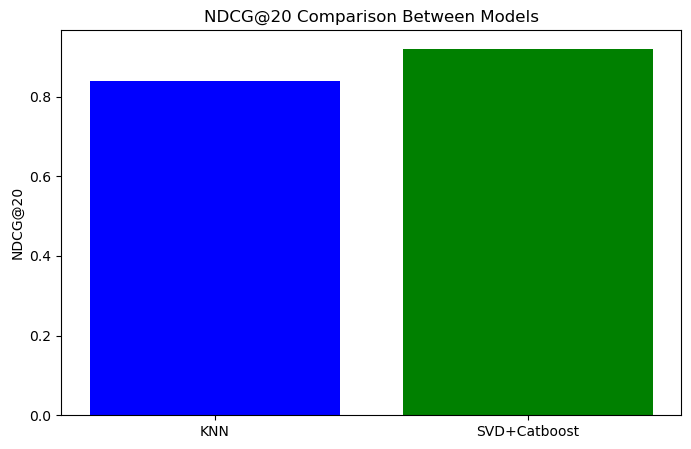

In [146]:
import matplotlib.pyplot as plt

# RMSE values for the models
models = ['KNN', 'SVD+Catboost']
rmse_values = [mean_ndcg, average_ndcg_svd_catboost]

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.bar(models, rmse_values, color=['blue', 'green', 'red'])
plt.ylabel('NDCG@20')
plt.title('NDCG@20 Comparison Between Models')
plt.show()

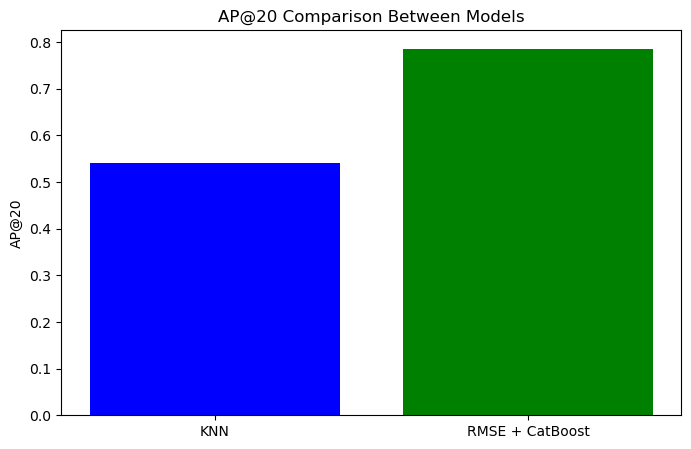

In [147]:
import matplotlib.pyplot as plt

# RMSE values for the models
models = ['KNN',  'RMSE + CatBoost']
rmse_values = [mean_ap, average_ap_svd_catboost]

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.bar(models, rmse_values, color=['blue', 'green', 'red'])
plt.ylabel('AP@20')
plt.title('AP@20 Comparison Between Models')
plt.show()